Import libraries

In [ ]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
import numpy as np
import time
import sys
from numpy.random import rayleigh
import matplotlib.pyplot as plt
import random


%matplotlib inline


# **Exercice 1**

Assume a parameter server that is located at the center of a circle area A of 100 meter of radius.
Suppose 10 devices randomly scattered within area (choose random positions of devices within
this circle). Plot the position of the server and the positions of the devices.


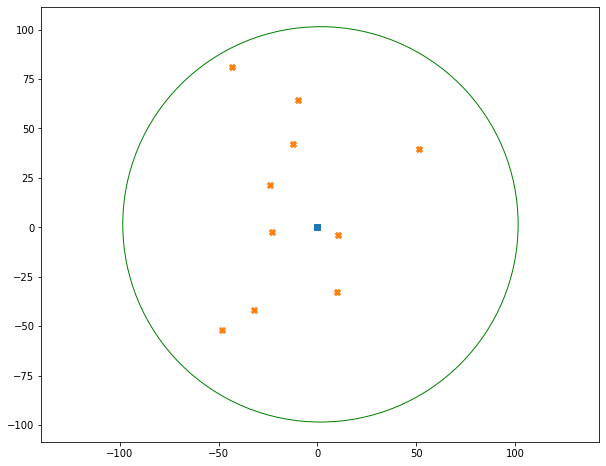

In [ ]:
def generatePoint(tres):
  x=[0]
  y=[0]
  for i in range(1,11):
    #generate a random radius and thetha for computing coordinates of devices
    theta = random.random()*2*np.pi
    n = random.randint(1,100)
    for j in range (i) :
      # use a treshold for keep a certain distance beetween device
      while  (np.sqrt( (n*np.cos(theta)-x[j])**2 + (n*np.sin(theta)-y[j])**2 )  < tres):
        theta = random.random()*2*np.pi
        n = random.randint(1,100)
    x.append(n*np.cos(theta))
    y.append(n*np.sin(theta))
  return x,y
x,y=generatePoint(10)
fig, ax = plt.subplots(1, figsize=(10, 8))

# Scatter the server
ax.scatter(x[0], y[0],marker="s")
#Scatter devices
ax.scatter(x[1:], y[1:],marker="X")
# Plot Circle 
cir = plt.Circle((1.5, 1.5), 100, color='g',fill=False)
ax.set_aspect('equal', adjustable='datalim')
ax.add_patch(cir)
plt.show()

Exercice 2

• We assume that all devices transmit over the same up-link channel using the same frequency
f = 2GHz. We assume that propagation channels between the devices and the parameter server
are attenuated by a path loss with β = 2 (β is the path loss exponent, the gains of antennas are
assumed equal to 1) and a multipath fading following a Rayleigh distribution of mean µ = 1.
Propose a function (in Python) that computes the channel capacity for each device at each
communication round T. (no multiple access policy is used).

In [ ]:
# function for Computing the distance beetween device and server 
def computeRadius(x,y) :
  return np.sqrt(x**2 + y**2 )

# function for Computing the parameter of rayleigh distribution 
def gammaRayleigh(meanrayleigh):
  return meanrayleigh*np.sqrt(2/np.pi)

# function for Computing the path loss
def pathLoss(r,f,Pt,beta,Gr,Gt):
  return 10*beta*np.log10((3*10**(8))/(4*np.pi*f*r)) + 10*np.log10(Pt) +  10*np.log10(Gr) + 10*np.log10(Gt)

# function for Computing the power received 
def powerReceived(meanrayleigh,r,f,Pt,beta,Gr,Gt):
  return 10*beta*np.log10((3*10**(8))/(4*np.pi*f*r)) - rayleigh(gammaRayleigh(meanrayleigh)) + 10*np.log10(Pt) +  10*np.log10(Gr) + 10*np.log10(Gt)

# function for Computing the capacity of one device 
def  capacity(meanrayleigh,r,f,N,Pt=1,beta=2,Gr=1,Gt=1):
  return np.log2( 1 + 10**( (powerReceived(meanrayleigh,r,f,Pt,beta,Gr,Gt) - 10*np.log10(N) ) / 10) )

# function for Computing the capacity of whole devices 
def capacityForAllDevice():
  C=[]
  for i in range(1,len(x)):
    C.append(capacity(1,computeRadius(x[i],y[i]),2*10**(9),10**(-14)))
  return C
C=capacityForAllDevice()
print("The channel capacity for each device at each communication round T is : \n",C)

The channel capacity for each device at each communication round T is : 
 [22.766245715174527, 20.295329999761297, 23.32658584504093, 23.152330949763403, 26.37568130085718, 24.434568404625903, 21.585311357028, 21.61377528812926, 21.15635230173949, 21.32263862214304]


# **Exercice 3**

Assume that devices have access to MNIST dataset. The training set of MNIST is equally devided
between devices ( 6000 image samples to each device). Using a federated learning procedure, each
device i locally trains its dataset Di and sends the gradient descent vector to the central server
for averaging. Due to resource-constrained communications, only a part of the gradient descent
is transmitted using top-K sparsification scheme. Write a function that computes the maximum
K for each channel that can be used for sparsification given a capacity C of the channel. (no
quantization is assumed)

Here for computing topK we use a method found in this article https://ecai2020.eu/papers/667_paper.pdf .The ideas is to send to the server the largest value of gradient and stock localy the smallest value. 

In [ ]:
from scipy.special import comb
# function for Computing the K weight  that device send to server 
def computeK(C,timedelay,d):
  K=1
  numbittosend = 33 * K + np.log2(comb(d,K)) 
  while (numbittosend < C*timedelay and K<d):
    K+=1
    numbittosend = 33  * K + np.log2(comb(d,K)) 
  return K-1

# function for Computing the topK  
def get_topK(Grad,C,timedelay):
  # Getting tne number K
  K = computeK(C,len(Grad),timedelay)
  # Constructing dict of gradient and their positions
  Gradabs=[abs(x) for x in Grad]
  zip_grad = dict(zip(Gradabs, range(len(Grad))))
  # Sorting the dict by value
  grad_sorted = dict(sorted(zip_grad.items(), key=lambda item: item[0],reverse=True))
  ind_topK = np.array(list(grad_sorted.values()))[0:K].tolist()
  topK = np.array(Grad)[ind_topK] 
  
  return topK,ind_topK

Grad=[-100+random.random()*100 for _ in range(6)] + [random.random()*100 for _ in range(4)]
topK,ind_topK = get_topK(Grad,20,9999)
print("Grad is: \n",Grad)
print("The TopK are : \n",topK)
print("And their positions are : \n",ind_topK)

Grad is: 
 [-36.496337342958796, -77.37275473756267, -86.26929545817165, -20.849193014122164, -89.41029080694894, -64.06331847659965, 47.34223120860155, 51.85417537622487, 42.693009652157734, 29.154157650901368]
The TopK are : 
 [-89.41029081 -86.26929546 -77.37275474 -64.06331848]
And their positions are : 
 [4, 2, 1, 5]


# **Exercice 4**

(Optional) Propose a neural network model (ideally a convolutional neural network model), to
predict the handwritten numbers of MNIST dataset. (Just the structure of the model in terms
of layers and nodes)

The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset.

It is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.

It is a widely used and deeply understood dataset and, for the most part, is “solved.” Top-performing models are deep learning convolutional neural networks that achieve a classification accuracy of above 99%, with an error rate between 0.4 %and 0.2% on the hold out test dataset.

The example below loads the MNIST dataset using the Keras API and creates a plot of the first nine images in the training dataset.

Train: X =  (60000, 28, 28)  y =  (60000,)
Train: X =  (10000, 28, 28)  y =  (10000,)


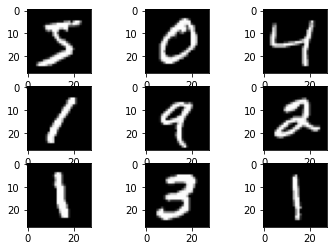

In [ ]:
#loading the mnist dataset using keras API
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X = ',trainX.shape, ' y = ' ,trainy.shape)
print('Train: X = ',testX.shape, ' y = ' ,testy.shape)
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

Define model

The model has two main aspects: the feature extraction front end comprised of convolutional and pooling layers, and the classifier backend that will make a prediction.

For the convolutional front-end, we can start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. The filter maps can then be flattened to provide features to the classifier.

Given that the problem is a multi-class classification task, we know that we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. This will also require the use of a softmax activation function. Between the feature extractor and the output layer, we can add a dense layer to interpret the features, in this case with 100 nodes.

All layers will use the ReLU activation function and the He weight initialization scheme, both best practices.

We will use a conservative configuration for the stochastic gradient descent optimizer with a learning rate of 0.01 and a momentum of 0.9. The categorical cross-entropy loss function will be optimized, suitable for multi-class classification, and we will monitor the classification accuracy metric, which is appropriate given we have the same number of examples in each of the 10 classes.

The define_model() function below will define and return this model.

There are many ways to change the model configuration in order to explore improvements over the reference model.

Two common approaches involve changing the capacity of the feature extraction part of the model or changing the capacity or function of the classifier part of the model. Perhaps the most influential point is a change in the feature extractor.

Increase in Model Depth

We can increase the depth of the feature extractor part of the model, following a VGG-like pattern of adding more convolutional and grouping layers with the same filter size, while increasing the number of filters. In this case we will add a double convolution layer with 64 filters each, followed by another max pooling layer.

The updated version of the define_model_opt () function with this change is listed below.

Two examples of execution is given below with first model and second model.

In [ ]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

def define_model_opt(classes):
	# initialize the input shape and channels dimension to be
	# "channels last" ordering
	inputShape = (28, 28, 1, 10)
	chanDim = -1
	# build the model using Keras' Sequential API
	model = Sequential([
		# CONV => RELU => BN => POOL layer set
		Conv2D(16, (3, 3), padding="same", input_shape=inputShape),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 2 => POOL layer set
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 3 => POOL layer set
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# first (and only) set of FC => RELU layers
		Flatten(),
		Dense(256),
		Activation("relu"),
		BatchNormalization(),
		Dropout(0.5),
		# softmax classifier
		Dense(classes),
		Activation("softmax")
	])
  
	# return the built model to the calling function
	return model.compile(optimizer=opt, loss=categorical_crossentropy,metrics=["acc"])



Example 1

> 98.592
> 98.733
> 98.575
> 98.817
> 98.808


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


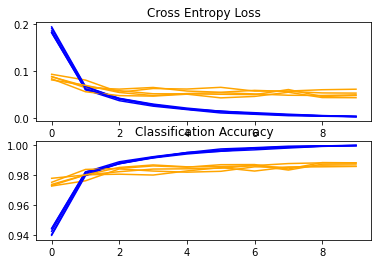

Accuracy: mean=98.705 std=0.104, n=5


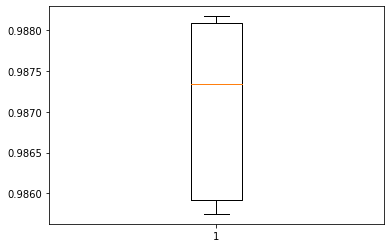

In [ ]:

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

# entry point, run the test harness
run_test_harness()
model = define_model()

Exemple 2

In [ ]:
def build_model(width, height, depth, classes):
	# initialize the input shape and channels dimension to be
	# "channels last" ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# build the model using Keras' Sequential API
	model = Sequential([
		# CONV => RELU => BN => POOL layer set
		Conv2D(16, (3, 3), padding="same", input_shape=inputShape),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 2 => POOL layer set
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 3 => POOL layer set
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# first (and only) set of FC => RELU layers
		Flatten(),
		Dense(256),
		Activation("relu"),
		BatchNormalization(),
		Dropout(0.5),
		# softmax classifier
		Dense(classes),
		Activation("softmax")
	])
	# return the built model to the calling function
	return model

def step(X, y):
  # keep track of our gradients
  with tf.GradientTape() as tape:
    # make a prediction using the model and then calculate the
    # loss
    pred = model(X)
    loss = categorical_crossentropy(y, pred)
  # calculate the gradients using our tape and then update the
  # model weights
  grads = tape.gradient(loss, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))
  return grads
 
# initialize the number of epochs to train for, batch size, and
# initial learning rate
EPOCHS = 3
BS = 64
INIT_LR = 1e-3

# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, trainY), (testX, testY)) = mnist.load_data()
# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
# one-hot encode the labels
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

# build our model and initialize our optimizer
print("[INFO] creating model...")
model = build_model(28, 28, 1, 10)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# compute the number of batch updates per epoch
numUpdates = int(trainX.shape[0] / BS)
GRAD=[]
# loop over the number of epochs
for epoch in range(0, EPOCHS):
  # show the current epoch number
  print("[INFO] starting epoch {}/{}...".format(
    epoch + 1, EPOCHS), end="")
  sys.stdout.flush()
  epochStart = time.time()
  # loop over the data in batch size increments
  for i in range(0, numUpdates):
    # determine starting and ending slice indexes for the current
    # batch
    start = i * BS
    end = start + BS
    # take a step
    gr=step(trainX[start:end], trainY[start:end])
	# show timing information for the epoch
  epochEnd = time.time()
  elapsed = (epochEnd - epochStart) / 60.0
  print("took {:.4} minutes".format(elapsed))

GRAD.append(gr)
 
# in order to calculate accuracy using Keras' functions we first need
# to compile the model
model.compile(optimizer=opt, loss=categorical_crossentropy,
	metrics=["acc"])
# now that the model is compiled we can compute the accuracy
(loss, acc) = model.evaluate(testX, testY)
print("[INFO] test accuracy: {:.4f}".format(acc))



[INFO] loading MNIST dataset...
[INFO] creating model...
[INFO] starting epoch 1/3...took 0.3091 minutes
[INFO] starting epoch 2/3...took 0.3073 minutes
[INFO] starting epoch 3/3...took 0.3089 minutes
313/313 [==============================] - 1s 3ms/step - loss: 0.0460 - acc: 0.9858
[INFO] test accuracy: 0.9895


# **Eercice 5**

(Optional) Implement the process of federated learning (computation of local gradients at the
devices, sparisification, and averaging). Assume that the sparsified vector is correctly received
at the parameter server. How many iterations are needed for your proposed model to converge.
What is the accuracy of the test using your proposed model?

In [ ]:
#Create local dataset for each device
def create_devices_data(image_list, label_list, num_devices=10, initial='device'):
    ''' return: a dictionary with keys 'device' name and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_device: number of fedrated members (device)
            initial: the devices'name prefix, e.g, device_1 
            
    '''
 
    #create a list of client names
    device_names = ['{}_{}'.format(initial, i+1) for i in range(num_devices)]
 
    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)
 
    #shard data and place at each client
    size = len(data)//num_devices
    shards = [data[i:i + size] for i in range(0, size*num_devices, size)]
 
    #number of devices must equal number of shards
    assert(len(shards) == len(device_names))
 
    return {device_names[i] : shards[i] for i in range(len(device_names))} 
 
 
def build_model(width, height, depth, classes):
    # initialize the input shape and channels dimension to be
    # "channels last" ordering
    inputShape = (height, width, depth)
    chanDim = -1
    # build the model using Keras' Sequential API
    model = Sequential([
        # CONV => RELU => BN => POOL layer set
        Conv2D(16, (3, 3), padding="same", input_shape=inputShape),
        Activation("relu"),
        BatchNormalization(axis=chanDim),
        MaxPooling2D(pool_size=(2, 2)),
        # (CONV => RELU => BN) * 2 => POOL layer set
        Conv2D(32, (3, 3), padding="same"),
        Activation("relu"),
        BatchNormalization(axis=chanDim),
        Conv2D(32, (3, 3), padding="same"),
        Activation("relu"),
        BatchNormalization(axis=chanDim),
        MaxPooling2D(pool_size=(2, 2)),
        # (CONV => RELU => BN) * 3 => POOL layer set
        Conv2D(64, (3, 3), padding="same"),
        Activation("relu"),
        BatchNormalization(axis=chanDim),
        Conv2D(64, (3, 3), padding="same"),
        Activation("relu"),
        BatchNormalization(axis=chanDim),
        Conv2D(64, (3, 3), padding="same"),
        Activation("relu"),
        BatchNormalization(axis=chanDim),
        MaxPooling2D(pool_size=(2, 2)),
        # first (and only) set of FC => RELU layers
        Flatten(),
        Dense(256),
        Activation("relu"),
        BatchNormalization(),
        Dropout(0.5),
        # softmax classifier
        Dense(classes),
        Activation("softmax")
    ])
    # return the built model to the calling function
    return model
 
 
def step(X, y):
  # keep track of our gradients
  with tf.GradientTape() as tape:
    # make a prediction using the model and then calculate the
    # loss
    pred = model(X)
    loss = categorical_crossentropy(y, pred)
  # calculate the gradients using our tape and then update the
  # model weights
  grads = tape.gradient(loss, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))
  return grads
 
 
def trainModel(trainX, trainY,Xtest, Ytest):
  # initialize the number of epochs to train for, batch size, and
  # initial learning rate
  EPOCHS = 10
  BS = 64
  INIT_LR = 1e-3
  # build our model and initialize our optimizer
  print("[INFO] creating model...")
  model = build_model(28, 28, 1, 10)
  opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
 
  # compute the number of batch updates per epoch
  numUpdates = int(trainX.shape[0] / BS)
  GRAD=[]
  gr=[]
  # loop over the number of epochs
  for epoch in range(0, EPOCHS):
      # show the current epoch number
      print("[INFO] starting epoch {}/{}...".format(
      epoch + 1, EPOCHS), end="")
      sys.stdout.flush()
      epochStart = time.time()
      # loop over the data in batch size increments
      for i in range(0, numUpdates):
       # determine starting and ending slice indexes for the current
       # batch
          start = i * BS
          end = start + BS
          # take a step
          gr=step(trainX[start:end], trainY[start:end])
    # show timing information for the epoch
  epochEnd = time.time()
  elapsed = (epochEnd - epochStart) / 60.0
  print("took {:.4} minutes".format(elapsed))
  GRAD.append(gr)
  model.compile(optimizer=opt, loss=categorical_crossentropy,
    metrics=["acc"])
  (loss, acc) = model.evaluate(Xtest, Ytest)
  return model,GRAD,loss,acc
 
ACC=[]
def run_global(timedelay):
    # Loading dataset
    Xtrain, Ytrain, Xtest, Ytest = load_dataset()
    # Spliting data for each device
    clusters = create_devices_data(Xtrain, Ytrain, num_devices=10, initial='device')
    # create a dictionnary which contain weight and indices which device send to the server
    Tosend={}
    # Compute capacity for
    C=capacityForAllDevice()
    k=0
    # Main loop for federativ learning
 
    for device in clusters.keys():
        trainX=[]
        trainY=[]
 
       # get data for device
        for i in range(len(clusters[device])) :
          trainX.append(clusters[device][i][0])
          trainY.append(clusters[device][i][1])
        
        trainX=np.array(trainX)
        trainY=np.array(trainY)
 
         # normalize data
        # trainX = np.expand_dims(trainX, axis=-1)
        # trainX = trainX.astype("float32") / 255.0
        # Xtest = np.expand_dims(Xtest, axis=-1)
        # Xtest = Xtest.astype("float32") / 255.0
        trainX, testX = prep_pixels(trainX, Xtest[0:1000])
        testY=Ytest[0:1000]
        print(f"Traing for {device}")  
        model, grad ,loss,acc= trainModel(trainX, trainY, testX, testY)
        print("[INFO] test accuracy: {:.4f}".format(acc))
        ACC.append(acc)
    # get gradient
        gs=[]
        for i in range(np.array(grad[-1]).shape[0]):
          gs=gs+list(np.array(np.array(np.array(grad[-1])[i]).flatten()))
        
        # get weight
        weight=[]
        w=model.trainable_weights
        for x in w :
          weight=weight+list(np.array(x).flatten())
 
        # find top k
        toK,ind_toK = get_topK(gs,C[k],timedelay)
        k+=1
 
    # Send the k weight and their positionto the server
        Tosend[device]=[np.array(weight)[ind_toK],ind_toK]
    
    print("[INFO] Total accuracy: {:.4f}".format(np.mean(ACC)))
    return Tosend
 
T=run_global(9999)

Traing for device_1
[INFO] creating model...
[INFO] starting epoch 1/10...[INFO] starting epoch 2/10...[INFO] starting epoch 3/10...[INFO] starting epoch 4/10...[INFO] starting epoch 5/10...[INFO] starting epoch 6/10...[INFO] starting epoch 7/10...[INFO] starting epoch 8/10...[INFO] starting epoch 9/10...[INFO] starting epoch 10/10...took 0.03024 minutes
32/32 [==============================] - 0s 3ms/step - loss: 2.3016 - acc: 0.1378
[INFO] test accuracy: 0.1330


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Traing for device_2
[INFO] creating model...
[INFO] starting epoch 1/10...[INFO] starting epoch 2/10...[INFO] starting epoch 3/10...[INFO] starting epoch 4/10...[INFO] starting epoch 5/10...[INFO] starting epoch 6/10...[INFO] starting epoch 7/10...[INFO] starting epoch 8/10...[INFO] starting epoch 9/10...[INFO] starting epoch 10/10...took 0.03025 minutes
32/32 [==============================] - 0s 3ms/step - loss: 2.3032 - acc: 0.0873
[INFO] test accuracy: 0.0870
Traing for device_3
[INFO] creating model...
[INFO] starting epoch 1/10...[INFO] starting epoch 2/10...[INFO] starting epoch 3/10...[INFO] starting epoch 4/10...[INFO] starting epoch 5/10...[INFO] starting epoch 6/10...[INFO] starting epoch 7/10...[INFO] starting epoch 8/10...[INFO] starting epoch 9/10...[INFO] starting epoch 10/10...took 0.03017 minutes
32/32 [==============================] - 0s 3ms/step - loss: 2.3017 - acc: 0.0984
[INFO] test accuracy: 0.0830
Traing for device_4
[INFO] creating model...
[INFO] starting epo

Above we implement the procees of Federative learning each device done the training in his own dataset localy and select the topk weight to send to the server.
After that come the step of aggregation done by the server. When the server received each weight it done the averaging and send new weigh to device and they update their model.
Above we notice that the accuracy in the first round of communication is low tha is comprehensible because the servernot done the aggregation yet. 